# Classificação de Estágios da Doença de Alzheimer

## Support Vector Machine

SVM (Support Vector Machine) é um algoritmo de aprendizado de máquina utilizado para classificação e regressão, que busca encontrar o hiperplano que melhor separa diferentes classes de dados, maximizando a margem entre elas. Ele pode lidar com dados lineares e não lineares usando a técnica de kernels.

### Bibliotecas

In [102]:
import os
import random
import numpy as np
import pandas as pd

In [103]:
from sklearn.calibration import label_binarize
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    hamming_loss,
    jaccard_score,
    log_loss,
    matthews_corrcoef,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

In [104]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

### Variáveis iniciais

In [105]:
# Valor fixo de seed para reprodutibilidade
random_seed = 42

# Pasta do dataset
dataset_folder = "../data/Alzheimer_MRI_4_classes_dataset" # Dataset original https://www.kaggle.com/datasets/marcopinamonti/alzheimer-mri-4-classes-dataset?select=Alzheimer_MRI_4_classes_dataset
# dataset_folder = "../data/Alzheimer_s_dataset/AugmentedAlzheimerDataset" # Dataset aumentado https://data.mendeley.com/datasets/ch87yswbz4/1
folders = ["NonDemented", "VeryMildDemented", "MildDemented", "ModerateDemented"]

# Número máximo de imagens a serem carregadas em cada classe
max_images_per_class = 400

### Random Seed

In [106]:
# Função para fixar a seed e garantir reprodutibilidade
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)

# Chamar a função com o seed desejado
set_seed(random_seed)

### Carregar dados

In [107]:
# Dicionário para mapear pastas (classes) a inteiros
class_to_int = {folder: idx for idx, folder in enumerate(folders)}
class_to_int

{'NonDemented': 0,
 'VeryMildDemented': 1,
 'MildDemented': 2,
 'ModerateDemented': 3}

In [108]:
# Função para carregar e pré-processar as imagens
def load_images(dataset_folder, folders, image_size=(176, 128), max_images_per_class=100):
    images = []
    labels = []
    for folder in folders:
        folder_path = os.path.join(dataset_folder, folder)
        if os.path.exists(folder_path):
            count = 0
            for img_name in os.listdir(folder_path):
                if count >= max_images_per_class:
                    break
                img_path = os.path.join(folder_path, img_name)
                try:
                    image = Image.open(img_path).convert("RGB")
                    image = image.resize(image_size)  # Redimensionar para 176x128
                    image = np.array(image).flatten()  # Flatten a imagem para 1D
                    images.append(image)

                    # labels.append(folder)
                    labels.append(class_to_int[folder])

                    count += 1
                except Exception as e:
                    print(f"Erro ao processar a imagem {img_name}: {e}")

    return np.array(images), np.array(labels)

# Carregar as imagens e os rótulos
X, y = load_images(dataset_folder, folders, max_images_per_class=max_images_per_class)

# Normalizar as imagens
X = X / 255.0  # Normalizar os valores dos pixels para o intervalo [0, 1]

### Rótulos

In [109]:
# Codificar os rótulos
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)

### Dividir em treino e teste

In [110]:
# Dividir os dados em treinamento e teste
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=random_seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

print("Forma dos dados de treino:", X_train.shape, y_train.shape)
print("Forma dos dados de teste:", X_test.shape, y_test.shape)

Forma dos dados de treino: (1011, 67584) (1011,)
Forma dos dados de teste: (253, 67584) (253,)


### Treinar o modelo

In [111]:
# Treinar um classificador SVM
model = SVC(kernel='linear', probability=True, random_state=random_seed, C=1.0)
model.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

### Predizer utilizando o modelo treinado

In [112]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [113]:
# target_names = label_encoder.classes_
target_names = [name for name, _ in sorted(class_to_int.items(), key=lambda x: x[1])]

### Métricas

In [114]:
# Acurácia

print("Acurácia:", accuracy_score(y_test, y_pred))

Acurácia: 0.932806324110672


In [115]:
# Relatório de classificação

print("Relatório de classificação:")
print(classification_report(y_test, y_pred, target_names=target_names))

Relatório de classificação:
                  precision    recall  f1-score   support

     NonDemented       0.92      0.92      0.92        87
VeryMildDemented       0.95      0.87      0.91        79
    MildDemented       0.92      1.00      0.96        69
ModerateDemented       1.00      1.00      1.00        18

        accuracy                           0.93       253
       macro avg       0.95      0.95      0.95       253
    weighted avg       0.93      0.93      0.93       253



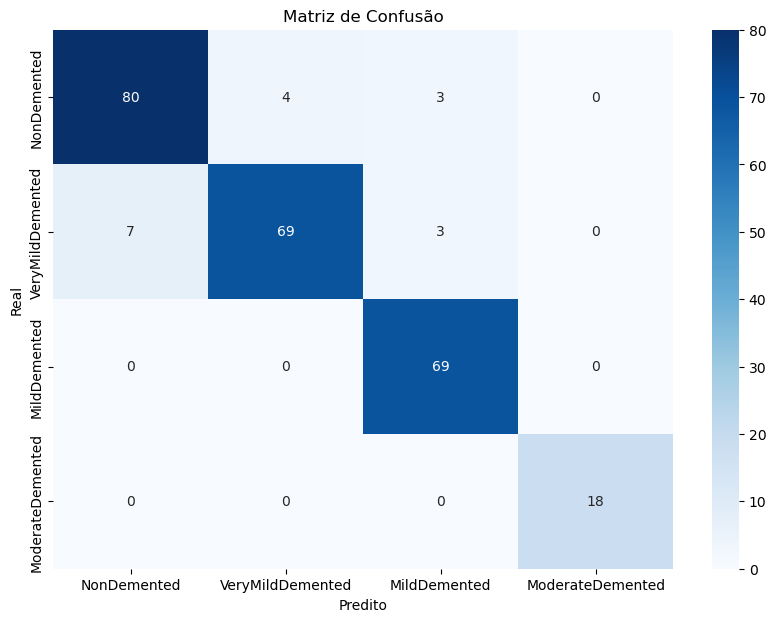

In [116]:
# Matriz de confusão
# É uma ferramenta visual que mostra o desempenho do modelo em cada classe

cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão usando Seaborn com a paleta Set2
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [117]:
# Área sobre a curva ou AUC para cada classe

y_test_binarized = label_binarize(y_test, classes=np.arange(len(folders)))
auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr')
print("AUC:", auc)

AUC: 0.9896746097803688


In [118]:
# Log Loss (Logarithmic Loss)
# Mede a incerteza das previsões. Penaliza previsões incorretas com alta confiança mais severamente do que previsões incorretas com baixa confiança.

log_loss_value = log_loss(y_test, y_pred_proba)
print("Log Loss:", log_loss_value)

Log Loss: 0.21177300074589087


In [119]:
# Cohen's Kappa
# Mede a concordância entre as previsões do modelo e os rótulos verdadeiros, ajustando para a concordância que ocorre por acaso.

kappa = cohen_kappa_score(y_test, y_pred)
print("Cohen's Kappa:", kappa)

Cohen's Kappa: 0.9047903661398149


In [120]:
# Hamming Loss
# Mede a fração de rótulos incorretamente previstos. É útil para problemas multilabel.

hamming = hamming_loss(y_test, y_pred)
print("Hamming Loss:", hamming)

Hamming Loss: 0.06719367588932806


In [121]:
# Jaccard Index
# Mede a similaridade entre os conjuntos de rótulos previstos e os rótulos verdadeiros.

jaccard = jaccard_score(y_test, y_pred, average='macro')
print("Jaccard Index:", jaccard)

Jaccard Index: 0.9005972827480133


In [122]:
# Matthews Correlation Coefficient (MCC)
# Considera todos os elementos da matriz de confusão e é uma métrica equilibrada que pode ser usada mesmo se as classes tiverem tamanhos muito diferentes.

mcc = matthews_corrcoef(y_test, y_pred)
print("Matthews Correlation Coefficient:", mcc)

Matthews Correlation Coefficient: 0.9055121134644886
